In [ ]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy
from collections import defaultdict
from itertools import combinations
from collections import Counter
from tqdm import tqdm
import numpy as np
import networkx as nx
import networkx.algorithms.community as nxcom
import scipy.stats as stats
from itertools import combinations
import pickle
from itertools import islice
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/EMZD/
#!wget https://github.com/shreeharshas/KaggleMST/raw/master/kaggle_visible_evaluation_triplets.zip
#!unzip "kaggle_visible_evaluation_triplets.zip"
file = "kaggle_visible_evaluation_triplets.txt"

/content/drive/MyDrive/Colab Notebooks/EMZD


In [ ]:
class GroupingSocieties:
  data_np = None
  user_song_rating = defaultdict(list)
  correlation_dictionary = defaultdict(list)
  song_id_uniq = None
  song_id_dct = {}
  G = None
  GT = None
  output = None
  def __init__(self):
    self.file = file
    new_file = input('New data or read pickle? y/n\n')
    if new_file == 'n':
      self.pickles()
    else:
      self.THRESHOLD_PEARSON = float(input('Pearson threshold: \n'))
      self.THRESHOLD_FILTERING = float(input('Filtering threshold: \n'))
      self.read_filename = input('Filename:\n')
      self.read_file(self.read_filename)
      self.prepare_data()
      self.calculate_correlation()
      self.create_graph()
      self.trawling()

  def pickles(self):
    read_correlations = input('Read correlations from file? y/n\n')
    if read_correlations == 'y':
      self.read_pickle(0)
    read_graph_data = input('Read graph data from file? y/n\n')
    if read_graph_data == 'y':
      self.read_pickle(1)Untitled3.
    read_trawling_calculations = input('Read trawling calculations from file? y/n\n')
    if read_graph_data == 'y':
      self.read_pickle(2)
    read_trawling_graph = input('Read trawling graph data from file? y/n\n')
    if read_trawling_graph == 'y':
      self.read_pickle(3)
    print("Nothing to do.")

  def hash_values(self,x):
    return hash(x) % 1_000_000

  def read_file(self, file):
    data = pd.read_csv(file, sep="\t", header=None)
    data.columns = ["user_id", "song_id", "frequency"]
    data_np = data.copy()
    data_np['user_id'] = data_np['user_id'].apply(self.hash_values)
    data_np = data_np.to_numpy()
    self.song_id_uniq = list(set(data_np[:,1]))
    self.data_np = data_np.copy()
    print("Dataset loaded.")
    print("Found: {} rows and {} columns".format(len(data.index),len(data.columns)))

  def give_song_new_id(self):
    for i, x in enumerate(self.song_id_uniq):
      if x not in self.song_id_dct:
        self.song_id_dct[x] = i

  def prepare_data(self):
    print("Creating dictionary for {user:[(song, rating)]}")
    self.give_song_new_id()
    for row in tqdm(self.data_np):
      song_id = self.song_id_dct.get(row[1])
      self.user_song_rating[row[0]].append((song_id, self.assign_rating(row[2])))

  def filtering_data(self):
    filtered_dict = {}
    for key, value in self.user_song_rating.items():
      if len(value) >= self.THRESHOLD_FILTERING:
        filtered_dict[key] = value
    return filtered_dict

  def assign_rating(self, frequency):
    if(frequency) == 1:
      return 1
    if 2 <= frequency < 4:
      return 2
    if 4 <= frequency < 8:
      return 3
    if 8 <= frequency < 13:
      return 4
    else:
      return 5

  def calculate_pearson(self, value, value2):
    value_np = np.asarray(value)
    value2_np = np.asarray(value2)

    inter, a_inter, b_inter = np.intersect1d(value_np[:,0], value2_np[:,0], return_indices=True)

    if len(inter) == 0:
      return 0

    set_arrays_size = len(value_np[:,0]) + len(value2_np[:,0])
    diff_a = (set_arrays_size - len(value_np[:,0]))
    diff_b = (set_arrays_size - len(value2_np[:,0]))

    a_inter_fixed = np.array(value_np[a_inter])
    b_inter_fixed = np.array(value2_np[b_inter])

    a_value = np.delete(value_np, a_inter, 0)
    b_value = np.delete(value2_np, b_inter, 0)

    diff_arr_a = np.zeros([diff_a,2],dtype=int)
    diff_arr_b = np.zeros([diff_b,2],dtype=int)

    a_inter_fixed = np.r_[a_inter_fixed, value_np]
    a_inter_fixed = np.r_[a_inter_fixed, diff_arr_a]

    b_inter_fixed = np.r_[b_inter_fixed, diff_arr_b]
    b_inter_fixed = np.r_[b_inter_fixed, value2_np]

    return stats.pearsonr(a_inter_fixed[:,1], b_inter_fixed[:,1])[0]

  def calculate_correlation(self):
    print("Calculating Pearson correlation coefficient...")
    filtered_dict = self.filtering_data()
    combination_of_users = combinations(filtered_dict.keys(), 2)
    for pair_of_users in tqdm(combination_of_users):
      correlation_value = self.calculate_pearson(filtered_dict[pair_of_users[0]], filtered_dict[pair_of_users[1]])

      if correlation_value > self.THRESHOLD_PEARSON or correlation_value < - self.THRESHOLD_PEARSON:
        self.correlation_dictionary[pair_of_users[0]].append(pair_of_users[1])
        self.correlation_dictionary[pair_of_users[1]].append(pair_of_users[0])

    print("Calculations complete.")
    pickles = input('Save correlations to pickle? y/n\n')
    if pickles == 'y':
      self.save_pickle(0,self.correlation_dictionary)

  def read_pickle(self,option):
    if option == 0:
      pickle_in = open("correlation.pickle","rb")
      self.correlation_dictionary = pickle.load(pickle_in)
      print("Loaded correlations.")
    if option == 1:
      pickle_in = open("graph_data.pickle","rb")
      self.G = pickle.load(pickle_in)
      print("Loaded graph data.")
    if option == 2:
      pickle_in = open("trawling_calculations.pickle","rb")
      self.output = pickle.load(pickle_in)
      print("Loaded trawling calculations.")
    if option == 3:
      pickle_in = open("trawling_graph_data.pickle","rb")
      self.GT = pickle.load(pickle_in)
      print("Loaded trawling graph data.")

  def save_pickle(self, option, obj):
    if option == 0:
      pickle_out = open("correlation.pickle","wb")
      pickle.dump(obj, pickle_out)
      pickle_out.close()
      print("Correlations saved.")
    if option == 1:
      pickle_out = open("graph_data.pickle","wb")
      pickle.dump(obj, pickle_out)
      pickle_out.close()
      print("Graph data saved.")
    if option == 2:
      pickle_out = open("trawling_calculations.pickle","wb")
      pickle.dump(self.output, pickle_out)
      pickle_out.close()
      print("Trawling calculations saved.")
    if option == 3:
      pickle_out = open("trawling_graph_data.pickle","wb")
      pickle.dump(obj, pickle_out)
      pickle_out.close()
      print("Trawling graph data saved.")

  def graph_options(self, labels_graph, size_graph, obj):
      if labels_graph == 'y':
        plt.figure(figsize=(size_graph, size_graph))
        nx.draw(obj, with_labels = True)
      else:
        plt.figure(figsize=(size_graph, size_graph))
        nx.draw(obj, with_labels = False)

  def random_graph(self, option, data):
    print_dict = defaultdict(list)
    for i in range(option):
      if data == 0:
        key, value = random.choice(list(self.correlation_dictionary.items()))
        print(f"{key} : {value}")
        for j in range(len(value)):
          print_dict[key].append(value[j])
      else:
        key, value = random.choice(list(self.output.items()))
        print(f"{key} : {value}")
        for j in range(len(value)):
          for k in range(2):
            print_dict[key].append(value[j][k])
    #print(print_dict)
    return nx.Graph(print_dict)

  def defined_graph(self, option, data):
    print_dict = defaultdict(list)
    for _ in range(option):
      key = int(input('Klucz: '))
      if data == 0:
        value = list(self.correlation_dictionary[key])
        print(f"{key} : {value}")
        for j in range(len(value)):
          print_dict[key].append(value[j])
      else:
        value = list(self.output[key])
        print(f"{key} : {value}")
        for j in range(len(value)):
          for k in range(2):
            print_dict[key].append(value[j][k])
      #print(print_dict)
    return nx.Graph(print_dict)

  def draw_graph(self):
    which_graph = int(input('Draw correlation or trawling graph? 0/1\n'))
    labels_graph = input('Labels? y/n\n')
    size_graph = int(input('Figsize?\n'))
    random_elements = input('Everything? y/n\n')
    if random_elements == 'n':
      random_dict = defaultdict(list)
      rand_amount = int(input("How many? number\n"))
      check_r = input('Randoms? y/n')
      if check_r == 'y':
        if which_graph == 0:
          Graph = self.random_graph(rand_amount, 0)
        else:
          Graph = self.random_graph(rand_amount, 1)
        self.graph_options(labels_graph, size_graph, Graph)
      else:
        if which_graph == 0:
          Graph = self.defined_graph(rand_amount, 0)
        else:
          Graph = self.defined_graph(rand_amount, 1)
        self.graph_options(labels_graph, size_graph, Graph)
    if random_elements == 'y':
      print("Drawning graph...")
      if which_graph == 0:
        self.graph_options(labels_graph, size_graph, self.G)
      else:
        self.graph_options(labels_graph, size_graph, self.GT)

  def create_graph(self):
    print("Creating graph data for correlations...")
    m_arr = {}
    correlation_dictionary = self.correlation_dictionary
    for key, value in correlation_dictionary.items():
      m_arr[key] = value
    self.G=nx.Graph(correlation_dictionary)

    print("Graph calculations completed.")
    save_graph = input('Save graph data to pickle? y/n\n')
    if save_graph == 'y':
      self.save_pickle(1, self.G)

  def trawling(self):
    c = defaultdict(int)
    print("Trawling")
    S = int(input("Support threshold?\n")) # może być duże
    T = int(input('Size?:\n')) # >3 wyrzuca ram
    print("K {},{}".format(S,T))
    print("Working...")
    correlation_dictionary = self.correlation_dictionary
    for value in correlation_dictionary.values():
      user_combination = combinations(value, T)
      for us in user_combination:
        c[us] += 1

    common = []
    for key, value in c.items():
      if value >= S:
        common.append(key)
    common = set(common)

    output = {}
    for key, value in tqdm(correlation_dictionary.items()):
      user_combination = combinations(value, T)
      tmpL = []

      [tmpL.append(us) for us in user_combination if us in common]

      if len(tmpL) != 0:
        output[key] = tmpL
    self.output = output
    print("Trawling calculations done.")
    save_output = input("Save trawling calculations? y/n\n")
    if save_output == 'y':
      self.save_pickle(2, output)
    self.GT = nx.Graph(output)
    save_output2 = input("Save trawling graph data? y/n\n")
    if save_output2 == 'y':
      self.save_pickle(3, output)
    print("Nothing else to do.\nFinished")

  def print_trawling_data(self):
    option = int(input('How many to print? \n'))
    output = self.output
    print_dict = defaultdict(list)
    for _ in range(option):
      key, value = random.choice(list(self.output.items()))
      print(f"{key} : {value}")
      for j in range(len(value)):
        for k in range(2):
          print_dict[key].append(value[j][k])
    G2=nx.Graph(print_dict)
    self.graph_options('y', 50, G2)
    """
    i= 0
    for key, value in self.output.items():
      print(f"{key} : {value}")
      for j in range(len(value)):
        for k in range(2):
          print_dict[key].append(value[j][k])
      #print(print_dict)
      i += 1
      if i == option:
        break
    G2=nx.Graph(print_dict)
    self.graph_options('y', 50, G2)
    """
    #G2.number_of_edge()
    #print("Edges:")
    #print(G2.edges(293517))
    #print("Neighbours:")
    #print(G2.neighbors(293517))


In [ ]:
society = GroupingSocieties()

New data or read pickle? y/n
y
Pearson threshold: 
0.6
Filtering threshold: 
50
Filename:
kaggle_visible_evaluation_triplets.txt
Dataset loaded.
Found: 1450933 rows and 3 columns
Creating dictionary for {user:[(song, rating)]}


100%|██████████| 1450933/1450933 [00:03<00:00, 476643.43it/s]


Calculating Pearson correlation coefficient...


37675it [00:07, 5213.71it/s]


Calculations complete.
Save correlations to pickle? y/n
y
Correlations saved.
Creating graph data for correlations...
Graph calculations completed.
Save graph data to pickle? y/n
y
Graph data saved.
Trawling
Support threshold?
25
Size?:
2
K 25,2
Working...


100%|██████████| 275/275 [00:00<00:00, 4342.40it/s]


Trawling calculations done.
Save trawling calculations? y/n
y
Trawling calculations saved.
Save trawling graph data? y/n
y
Trawling graph data saved.
Nothing else to do.
Finished


kaggle_visible_evaluation_triplets.txt

In [ ]:
society.correlation_dictionary

defaultdict(list,
            {1801: [196961,
              17510,
              903086,
              69717,
              374751,
              319723,
              51353,
              799728],
             15221: [865786,
              730409,
              829553,
              857139,
              154754,
              698598,
              926554,
              622561,
              137507,
              721210,
              650663,
              711256,
              762814,
              549425,
              659013,
              249797,
              346797,
              319723,
              51353,
              113978,
              431272],
             17171: [152012,
              30401,
              188644,
              373111,
              362057,
              829553,
              857139,
              528017,
              143859,
              989893,
              417550,
              49547,
              539455,
              944111,
              457335

Draw correlation or trawling graph? 0/1
0
Labels? y/n
y
Figsize?
20
Everything? y/n
n
How many? number
3
Randoms? y/nn
Klucz: 574403
574403 : [42299, 353527, 873328, 56811, 971203, 942358, 582644, 524724, 433499, 414858, 687273, 227748, 139, 51464, 884858, 694600, 569599, 905286, 523506, 664889, 981948, 525418, 993532, 851462, 390752, 321066, 360924, 597813, 119391, 797417, 394196, 277022, 789902, 7483, 751734, 238716, 778344, 29999, 900193, 253914, 465812, 90154, 110296, 864409, 189869, 597583, 914305, 384997, 405680, 906180, 422096, 106264, 875325, 923382, 362669, 848538, 276625]
Klucz: 688736
688736 : [794885, 174832, 478614, 359658, 971203, 576857, 622972, 387304, 630925, 952267, 623000, 658608, 940983, 197052, 678079, 287973, 433499, 414858, 237975, 227748, 346628, 816081, 657574, 315570, 227153, 258972, 993532, 412917, 699545, 851462, 923890, 603645, 325466, 351560, 119391, 797417, 396985, 647266, 514204, 760815, 848500, 663139, 900193, 741390, 893600, 296573, 407136, 171996, 515

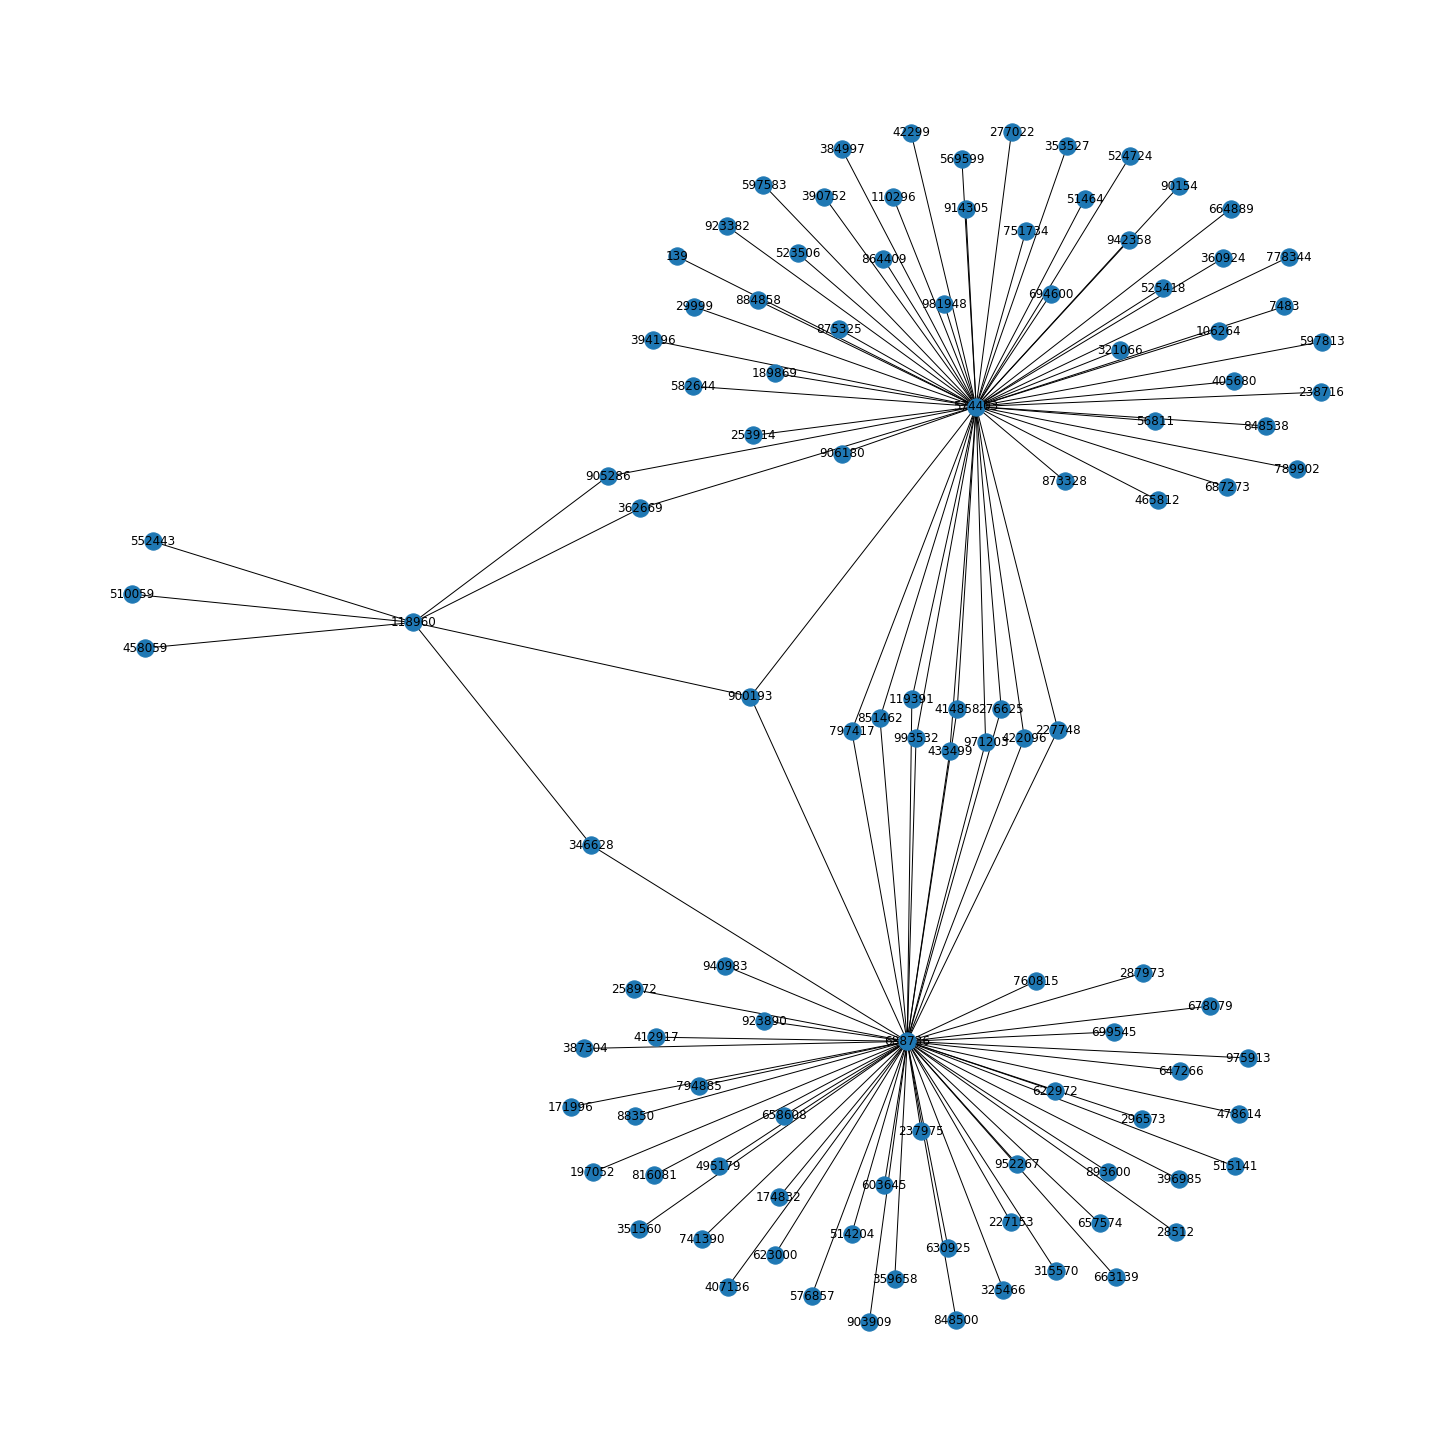

In [ ]:
society.draw_graph()

How many to print? 
10
597813 : [(414858, 396985), (414858, 574403), (414858, 253914), (414858, 975913), (414858, 822738), (396985, 574403), (396985, 253914), (396985, 975913), (396985, 822738), (574403, 975913), (253914, 975913), (975913, 822738)]
519156 : [(433499, 523506), (433499, 118023), (433499, 744495), (433499, 87142), (523506, 87142), (118023, 744495), (118023, 87142), (744495, 87142)]
437297 : [(56811, 315570), (56811, 326699), (56811, 82852), (56811, 975913), (56811, 276625), (315570, 326699), (315570, 82852), (315570, 975913), (315570, 276625), (326699, 82852), (326699, 975913), (326699, 276625), (82852, 975913), (82852, 276625), (975913, 276625)]
552443 : [(813026, 478614), (813026, 56811), (813026, 89493), (813026, 197052), (813026, 219398), (813026, 345319), (813026, 414858), (813026, 694600), (813026, 801404), (813026, 326699), (813026, 851462), (813026, 119391), (813026, 396985), (813026, 592626), (813026, 514204), (813026, 751734), (813026, 110296), (813026, 171996),

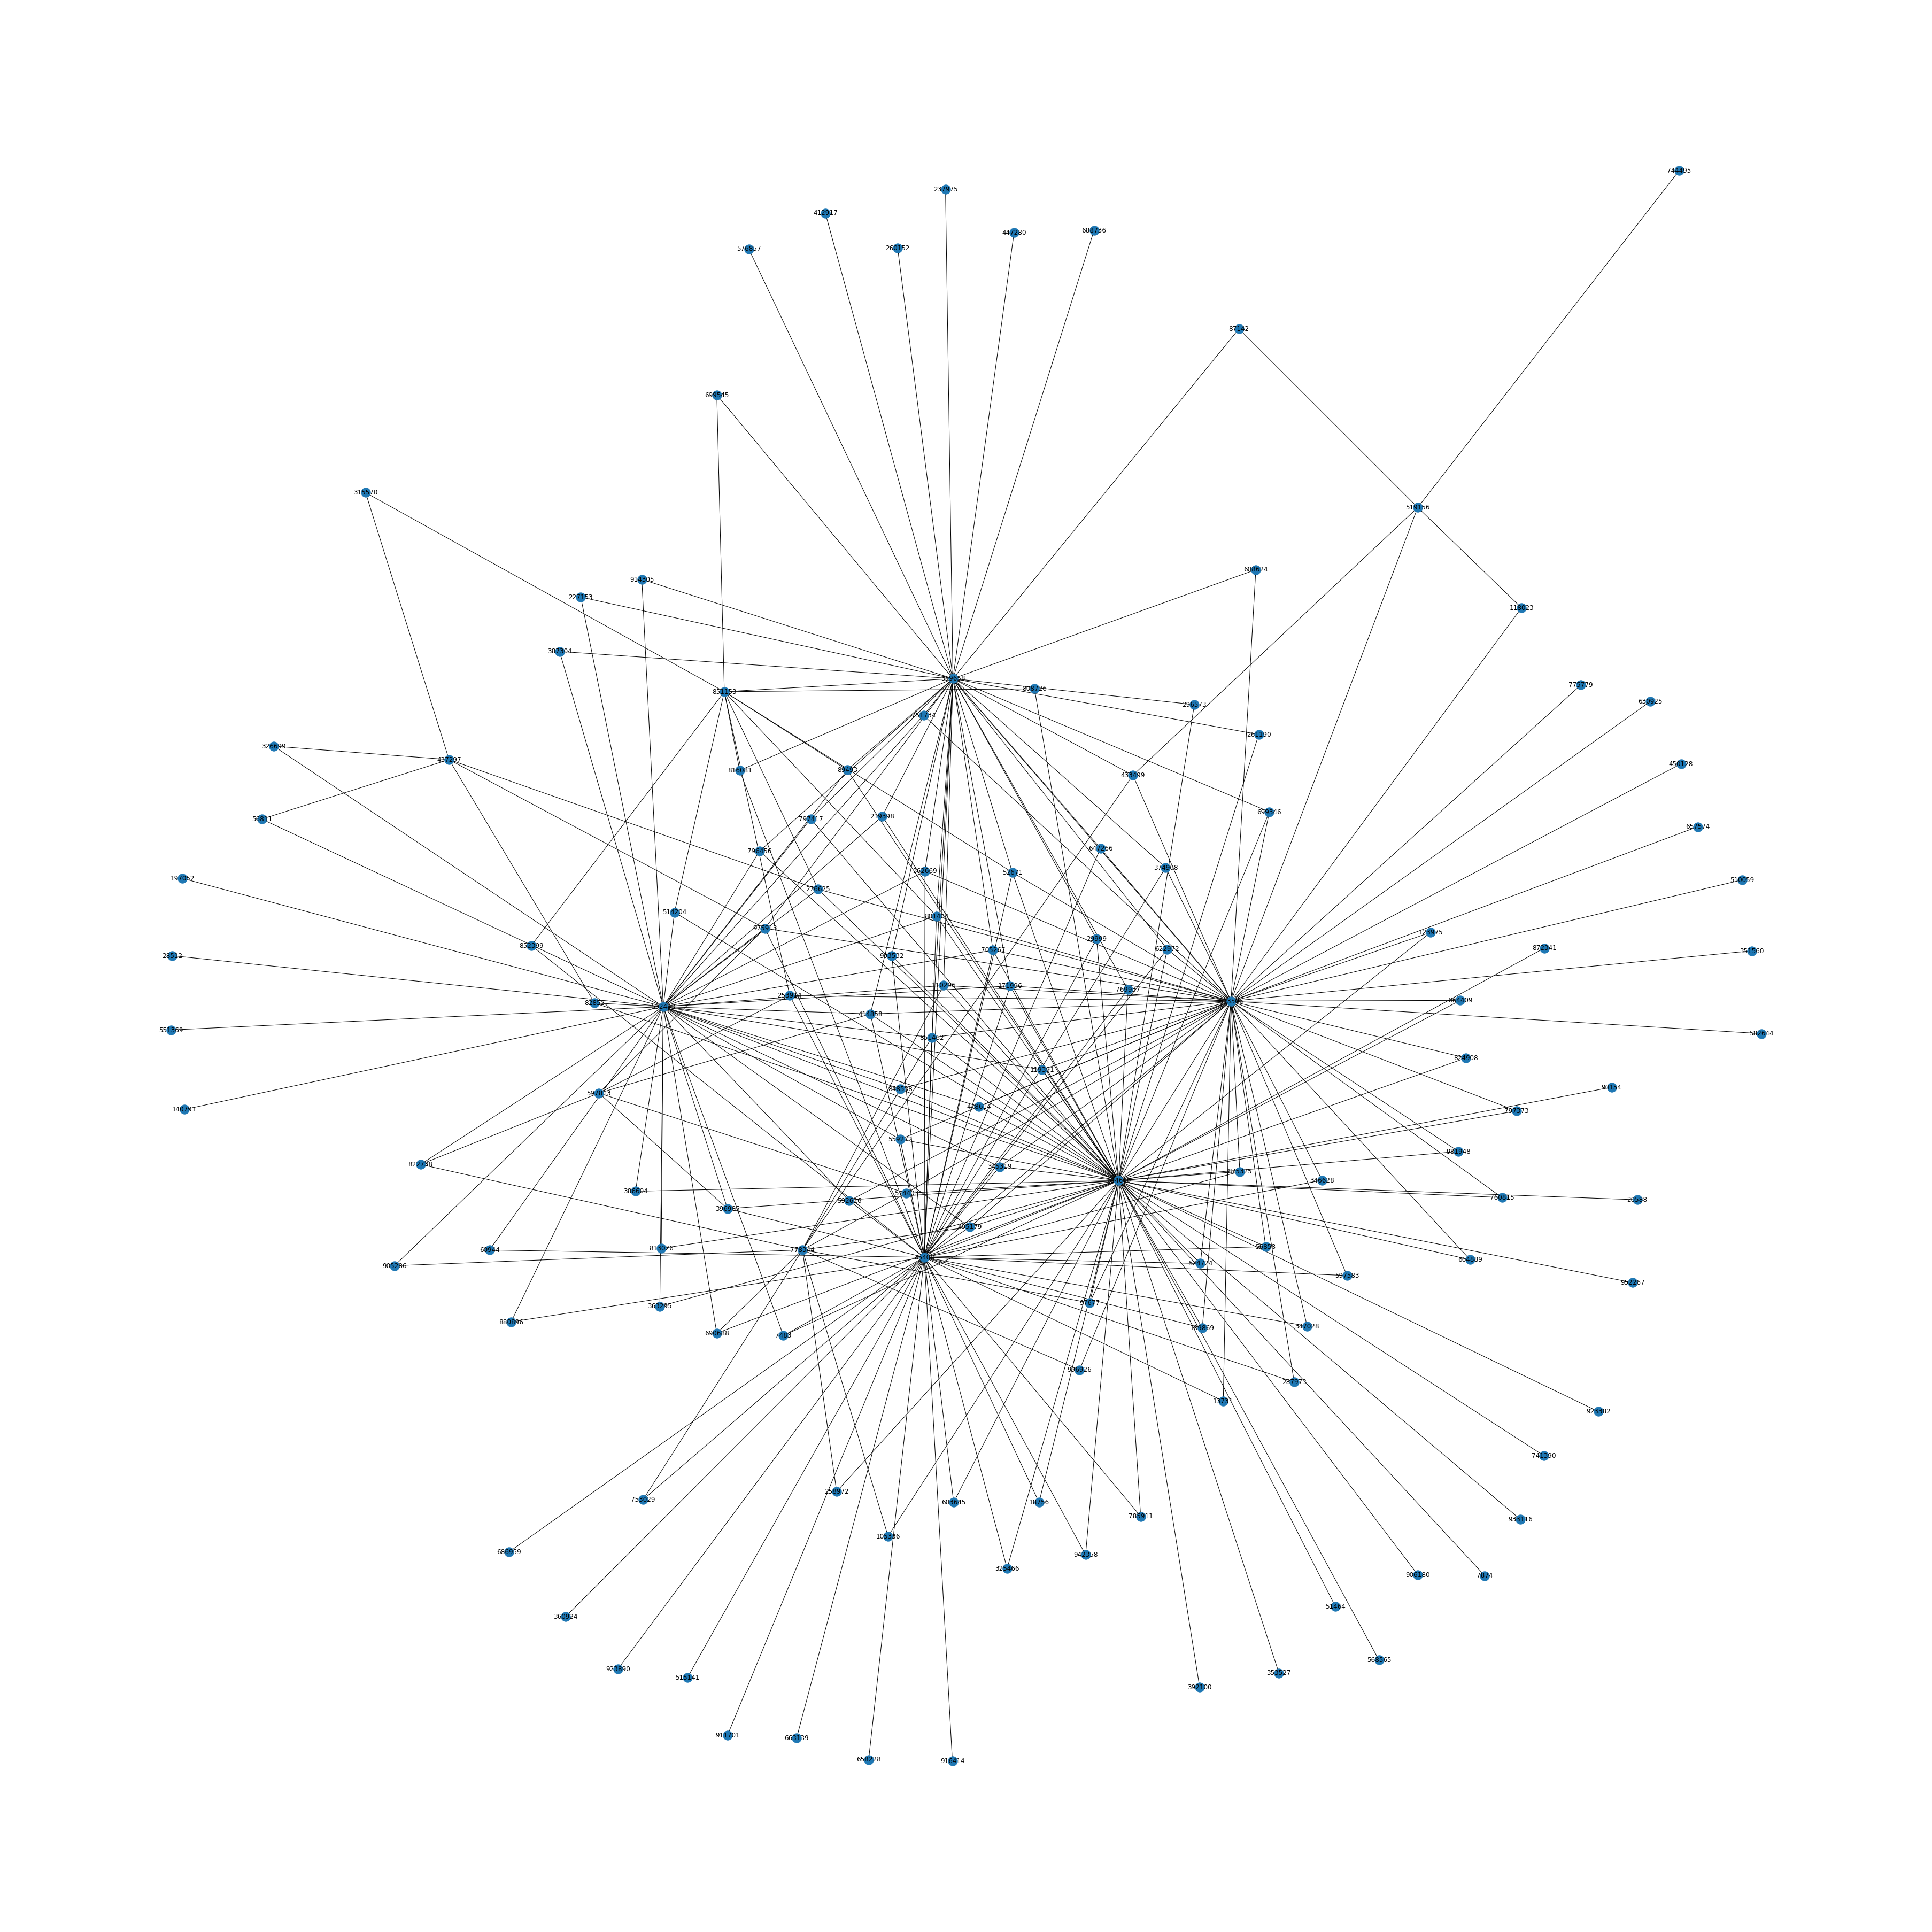

In [ ]:
b = society.print_trawling_data()

Draw correlation or trawling graph? 0/1
1
Labels? y/n
y
Figsize?
20
Everything? y/n
n
How many? number
10
Randoms? y/ny
844582 : [(250790, 291316), (250790, 489841), (250790, 300063), (250790, 404701), (250790, 534305), (692690, 291316), (692690, 528227), (692690, 489841), (692690, 300063), (692690, 295007), (291316, 528227), (291316, 489841), (291316, 300063), (291316, 404701), (291316, 4765), (291316, 534305), (291316, 295007), (528227, 489841), (528227, 300063), (528227, 404701), (528227, 534305), (528227, 295007), (489841, 300063), (489841, 404701), (489841, 4765), (489841, 534305), (489841, 295007), (300063, 404701), (300063, 4765), (300063, 534305), (300063, 295007), (404701, 534305), (404701, 295007), (4765, 295007), (534305, 295007)]
273363 : [(88610, 227233), (88610, 192166), (88610, 163181), (88610, 352883), (88610, 46593), (88610, 860416), (88610, 367054), (88610, 548027), (88610, 692308), (88610, 108237), (88610, 658685), (88610, 727647), (88610, 155762), (88610, 47822), (8

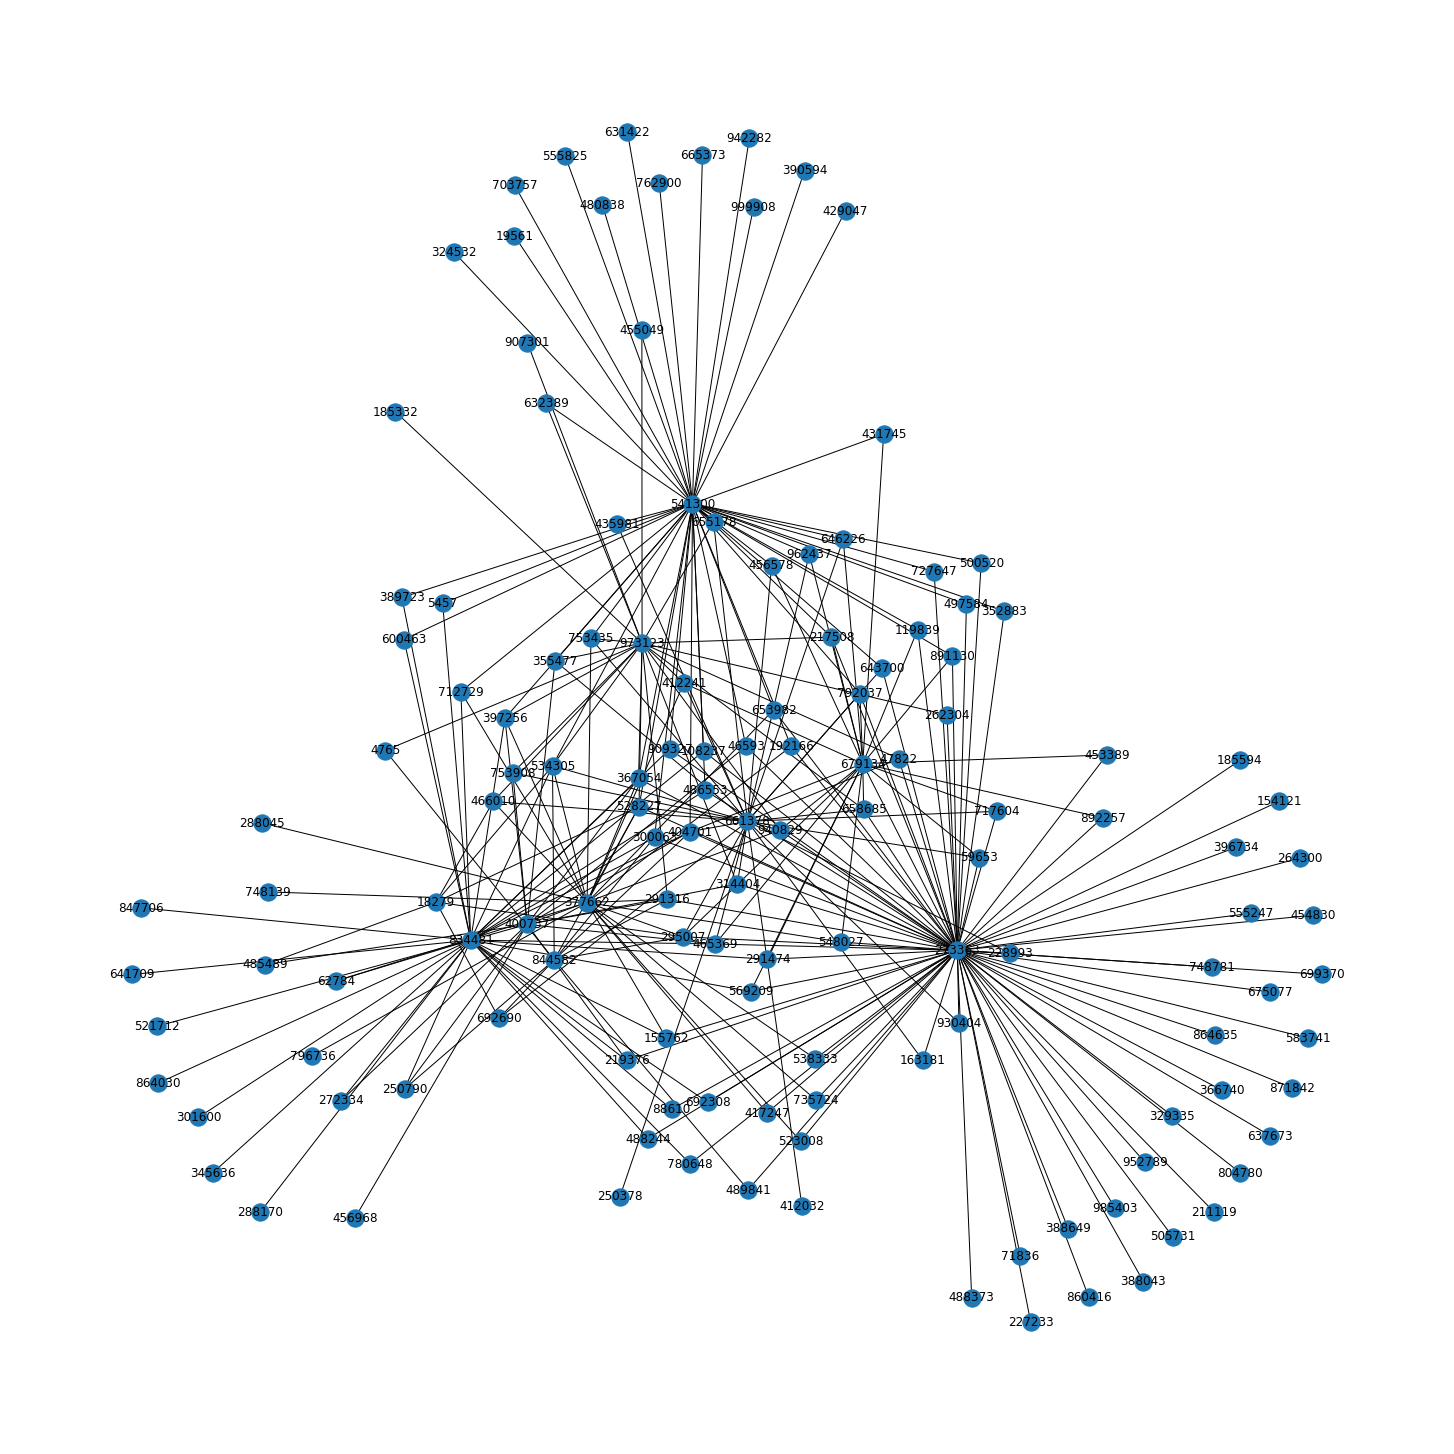

In [ ]:
society.draw_graph()

In [ ]:
society.draw_graph()

In [ ]:
society.correlation_dictionary

In [ ]:
society.output